# 基于PyTorch LSTM + Attention和BERT Transformer检测网暴推文

这个项目是关于分析关于网络欺凌的推文，目标是在PyTorch上使用带有注意力的LSTM和BERT进行情感分析，以预测一条推文是否与网络欺凌有关。 <br>
特别是，欺凌推文分为四类：宗教、年龄、种族和性别。 <br>
该项目分为以下几个部分：
- 数据导入
- 使用自定义函数进行文本清洗
- 朴素贝叶斯基线模型分类器
- LSTM RNN的数据准备：标记化
- 带有注意力的PyTorch LSTM RNN分类器
- BERT的数据准备：标记化
- PyTorch BERT分类器
- 结果汇总


# 主要结果总结:

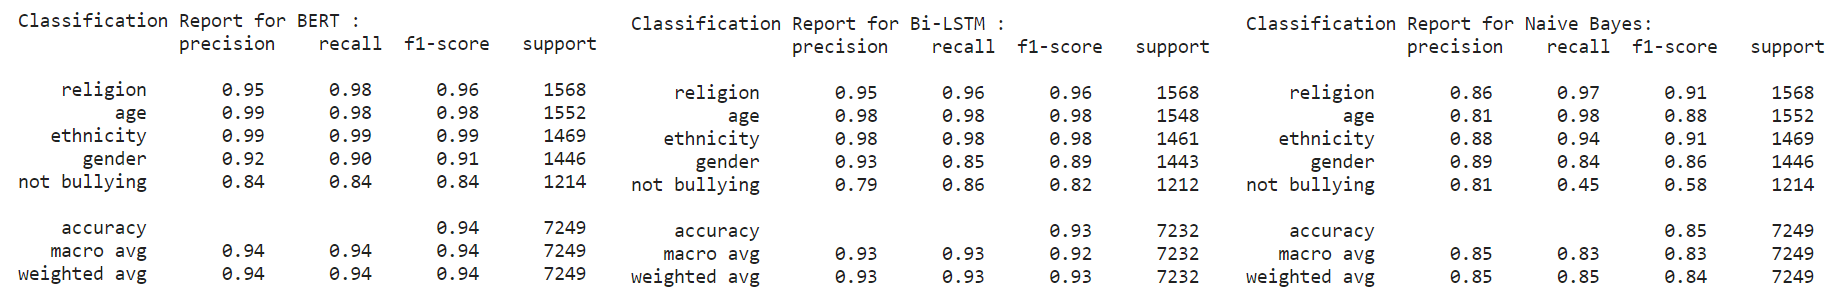

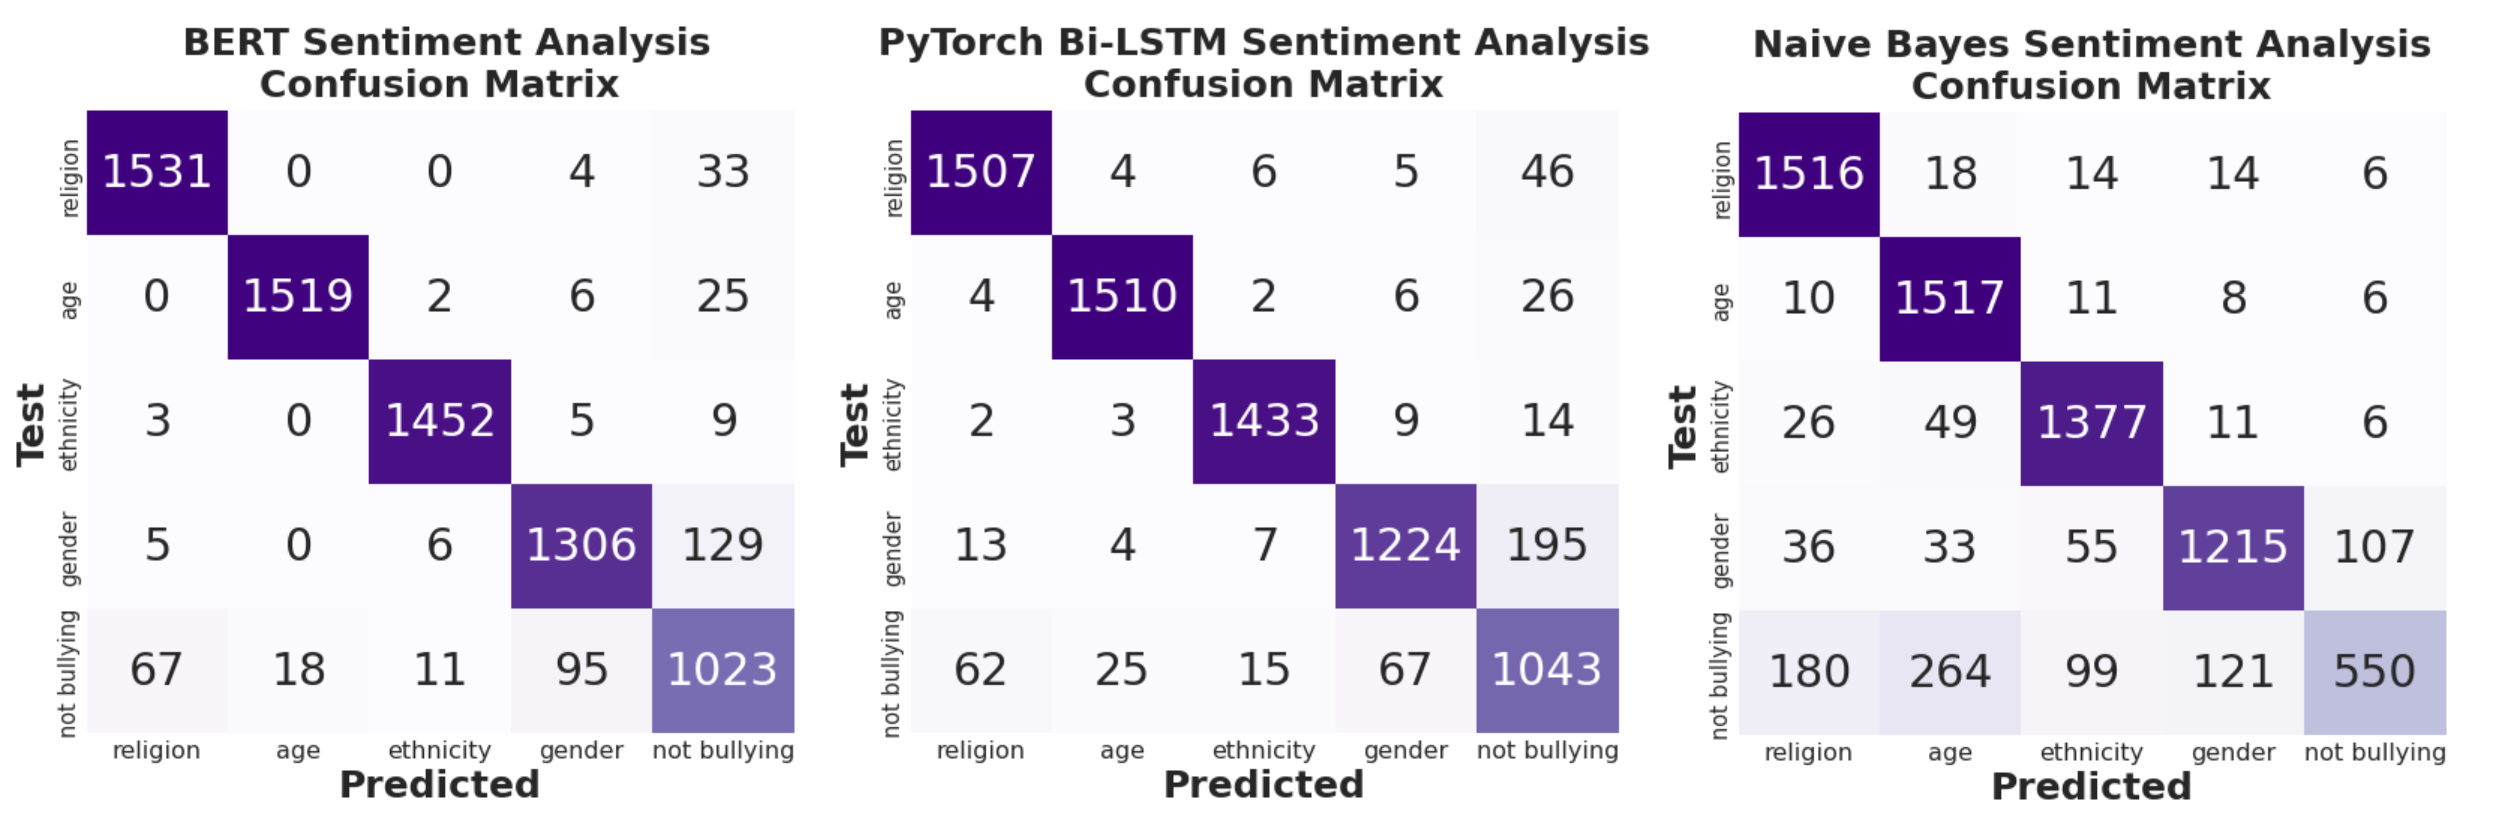


**朴素贝叶斯基线分类器在数据集上表现相当不错，所有类别的总体准确率为87%。<br>
另一方面，PyTorch的带有注意力机制的定制LSTM RNN实现了93%的准确率，其中一些类别的F1得分超过95%。**<br>
**最后，BERT表现最佳，总体准确率约为95%，F1得分超过96%。**<br>
总体来说，算法能够正确区分欺凌推文的不同主题，并且对于**人口较少的 "非网络欺凌" 类和 "性别" 类**（与其他类别相比，精确度和召回率较低）**有些更多的困难**。<br>
因此，**收集更多这类数据**可能是提高准确率和F1得分的好主意。


In [1]:
!nvidia-smi
# 报告写cuda版本，显存大小

Tue May 14 09:57:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              27W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv


## 自定义函数定义:

In [3]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16) 
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

In [4]:
pip install langdetect

     |████████████████████████████████| 981 kB 7.4 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=2288b39fe7a730afd455a79be0403bdc8a47c26fea773e7eb79cefd994effc75
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install contractions

     |████████████████████████████████| 289 kB 7.2 MB/s            
     |████████████████████████████████| 101 kB 10.7 MB/s           
Note: you may need to restart the kernel to use updated packages.


## 导入库

In [6]:
# 用于通用目的的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 文本清洗
import re
import string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# 数据预处理
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from langdetect import detect, LangDetectException
import contractions
from nltk.tokenize import word_tokenize

# 朴素贝叶斯
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

# Transformers library for BERT
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix

import time

# 设置种子，实现可复现
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# 设置图表样式
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

# 为文本清洗定义停用词
stop_words = set(stopwords.words('english'))

# 初始化用于文本清洗的词形还原器
lemmatizer = WordNetLemmatizer()

<Figure size 432x288 with 0 Axes>

## Data Import

In [7]:
df = pd.read_csv("/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv")

In [8]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


首先，我们使用较短的词汇重命名列名，以便于引用。


In [10]:
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

### 是否存在重复的推文？


In [11]:
df.duplicated().sum()

36

存在一些重复的推文，删除它们。


In [12]:
df = df[~df.duplicated()]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47656 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       47656 non-null  object
 1   sentiment  47656 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


### 各类别数据是否均衡？



In [14]:
df.sentiment.value_counts()

religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: sentiment, dtype: int64

各类别数据均衡。


# 推文文本深度清洗


定义自定义函数来清洗推文的文本。

In [15]:
# 从文本中清除emoji表情符号
def strip_emoji(text):
    return emoji.get_emoji_regexp().sub("", text)

# 移除标点符号、停用词、链接、提及和换行符
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # 用空格替换换行符和回车符，并转换为小写
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # 移除链接 和 @人
    text = re.sub(r'[^\x00-\x7f]', '', text)  # 移除非ASCII字符
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# 清洁句子末尾的标签，并保留句子中间的标签，只移除#符号
def clean_hashtags(tweet):
    # 移除句子末尾的标签
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()
    
    # 移除句子中间标签的#符号
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()
    
    return new_tweet

# 过滤一些单词中存在的特殊字符，如 & 和 $
def filter_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# 移除多余空格
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

# 检查文本是否为英文的函数，如果不是则返回空字符串
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# 展开缩写
def expand_contractions(text):
    return contractions.fix(text)

# 移除数字
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# 词形还原单词
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# 移除短词
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# 用其基本形式替换拉长的单词
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# 移除重复的标点符号
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# 移除多余的空格
def remove_extra_whitespace(text):
    return ' '.join(text.split())

def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# 移除推文开头和结尾的空格
def remove_spaces_tweets(tweet):
    return tweet.strip()

# 移除短推文
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# 按顺序调用所有清洗函数
def clean_tweet(tweet):
    tweet = strip_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # 移除单词之间的多余空格
    return tweet

In [16]:
df['text_clean'] = [clean_tweet(tweet) for tweet in df['text']]

In [17]:
df.head()

,text,sentiment,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thanks head concerned another angry dude t...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish account like is...


### 在清洗之后是否存在重复的推文？


In [18]:
print(f'There are around {int(df["text_clean"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 6255 duplicated tweets, we will remove them.


In [19]:
df.drop_duplicates("text_clean", inplace=True)

移除了清洗后的重复的推文。清洗后各类别是否均衡？

In [20]:
df.sentiment.value_counts()

religion               7915
age                    7815
ethnicity              7420
gender                 7283
not_cyberbullying      6065
other_cyberbullying    4903
Name: sentiment, dtype: int64

很多标记为“其他网络欺凌”other_cyberbullying类别的推文已经被移除。由于与其他类别相比，这个类别非常不平衡，且看起来过于“通用”，所以决定移除标记属于这个类别的推文。<br>
注：通过执行一些测试，预测“其他网络欺凌”的f1得分约为60%，与其它f1得分（使用LSTM模型约为95%）相比，这个值要低得多。这支持了我们移除这个通用类别的决定。

In [21]:
df = df[df["sentiment"]!="other_cyberbullying"]

然后还定义了一个类别名称列表，这对于未来的图表将非常有用。

In [22]:
sentiments = ["religion","age","ethnicity","gender","not bullying"]

# 推文长度分析


定义一个新的数据框列，其中包含清洗后的推文长度，以单词数量为单位。


In [23]:
df['text_len'] = [len(text.split()) for text in df.text_clean]

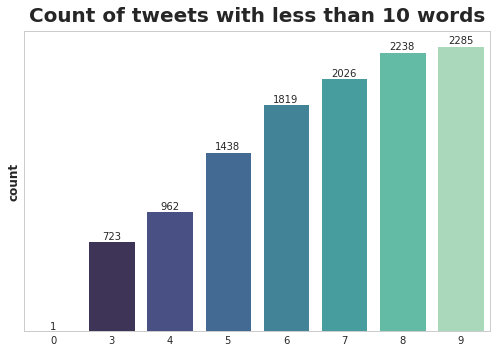

In [24]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

### 长推文如何处理？

In [25]:
df.sort_values(by=['text_len'], ascending=False)

,text,sentiment,text_clean,text_len
44035,You so black and white trying to live like a n...,ethnicity,black white trying live like nigger pahahahaha...,173
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",ethnicity,fuck obama dumb as nigger bitch ltthis whore s...,151
1317,@EurekAlertAAAS: Researchers push to import to...,not_cyberbullying,researcher push import top antibullying progra...,138
33724,"... I don't feel guilty for killing him, I jus...",age,feel guilty killing feel guilty enjoyed tormen...,136
10922,don't make rape jokes!!! don't make gay jokes!...,gender,make rape joke make gay joke oh fat joke okay ...,121
...,...,...,...,...
7643,Bully - missed this game.,not_cyberbullying,bully missed game,3
7639,"@NewIdeamagazine No, that kid is just a brat #mkr",not_cyberbullying,kid brat mkr,3
1454,Pretty? Er......no. #MKR,not_cyberbullying,pretty erno mkr,3
1455,#MemoriesInSchool fire extinguisher with @kapp...,not_cyberbullying,memoriesinschool fire extinguisher,3


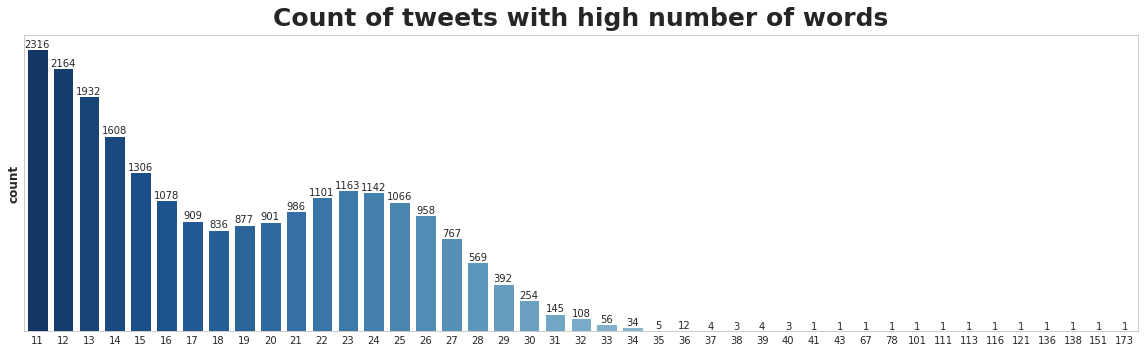

In [26]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

将移除过长的推文（删除df中超过99.5%的文本长度的那些行）

In [27]:
df = df[df['text_len'] < df['text_len'].quantile(0.995)]

然后，查看最长推文的长度。

In [28]:
max_len = np.max(df['text_len'])
max_len 

31

In [29]:
df.sort_values(by=["text_len"], ascending=False)

,text,sentiment,text_clean,text_len
38338,He's relatable to teens. He's a kid in High sc...,age,relatable teen kid high school trying get get ...,31
19046,Dong Zong & SJKC are like international privat...,religion,dong zong sjkc like international private scho...,31
32152,I was bullied in early high school. Then lost ...,age,bullied early high school lost thirty pound le...,31
33116,I was bullied all through grade school into hi...,age,bullied grade school high school one year move...,31
8182,"Yeah, but he already had his brain damaged. He...",gender,yeah already brain damaged might able saved ma...,31
...,...,...,...,...
821,@SuzieZUMO i seriously only see white.,not_cyberbullying,seriously see white,3
820,class should be cancel. #Unisza,not_cyberbullying,class cancel unisza,3
6293,Where is #mkr located tonight?,not_cyberbullying,mkr located tonight,3
10996,RT @Dezzantibus: @MT8_9 @Brittany_Blade @Judgy...,gender,rt think leave,3


## 情感列编码


通过序数编码进行编码

In [30]:
df['sentiment'] = df['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})

## 训练集、测试集分割


现在需要将数据集分割为训练集和测试集。

In [31]:
X = df['text_clean']
y = df['sentiment']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)  # 训练/测试：8/2

## 训练集、验证集分割


此外，进一步分割训练集，分出验证集用于监控准确性和损失，以避免模型训练过程中的过拟合。


In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)  # 训练/验证：8/2

In [34]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5015],
       [   1, 4967],
       [   2, 4711],
       [   3, 4631],
       [   4, 3879]])

各类别数据不平衡，因此要对训练集进行过采样，以便所有类别的数量都与最多类别的数量相同。


# 训练集过采样

In [35]:
# 来自imblearn库的RandomOverSampler类进行过采样，用于解决机器学习数据集中类别不均衡。
ros = RandomOverSampler()
# 将特征集X_train和标签集y_train转换成二维数组，然后使用fit_resample方法对数据进行拟合和过采样
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
# 将重新采样的特征X_train和重新采样的标签y_train打包成列表，然后将列表转换成DataFrame。DataFrame的列名为'text_clean'和'sentiment'。
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'sentiment']);

In [36]:
X_train = train_os['text_clean'].values
y_train = train_os['sentiment'].values

In [37]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5015],
       [   1, 5015],
       [   2, 5015],
       [   3, 5015],
       [   4, 5015]])

# 朴素贝叶斯模型

实施的第一个算法是朴素贝叶斯，作为一个简单的基线模型。<br>
为了使用这个算法，需要对文本数据进行预处理。<br>
首先，我们将使用CountVectorizer创建一个词袋模型。<br>

In [38]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

然后应用TF-IDF变换，根据单词的频率为不同的单词关联权重（更罕见的单词将被赋予更多的权重）。

In [39]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

最后创建朴素贝叶斯模型实例。

In [40]:
nb_clf = MultinomialNB()

In [41]:
nb_clf.fit(X_train_tf, y_train)

MultinomialNB()

In [42]:
nb_pred = nb_clf.predict(X_test_tf)

In [43]:
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=sentiments))

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

    religion       0.85      0.97      0.90      1567
         age       0.80      0.98      0.88      1553
   ethnicity       0.89      0.91      0.90      1472
      gender       0.88      0.83      0.86      1447
not bullying       0.79      0.46      0.58      1213

    accuracy                           0.85      7252
   macro avg       0.84      0.83      0.82      7252
weighted avg       0.84      0.85      0.83      7252



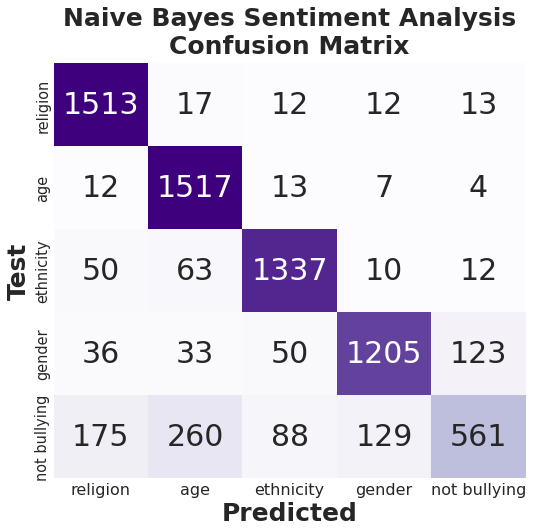

In [44]:
conf_matrix(y_test,nb_pred,'Naive Bayes Sentiment Analysis\nConfusion Matrix', sentiments)

**该算法的性能得分非常好，总体准确率为87%。<br>
我们可以观察到，对于数量较多的类别，预测的F1得分非常高（超过85%），而对于“非网络欺凌”not bullying 类别，得分则要低得多（58%）。**


*接下来我们将实施一个更复杂的算法来进行分类，目标是实现比基线朴素贝叶斯模型更高的准确率。*


# PyTorch LSTM RNN w/ Attention

将使用PyTorch定义一个自定义的单向和双向LSTM，以便对推文进行情感分析。

## LSTM的数据预处理


对数据进行预处理：<br>
特别是要使用自定义函数对句子进行标记化<br>
即将句子转换为数字列表，并填充到句子中的最大单词数。

In [45]:
def Tokenize(column, seq_len):
    ## 从列中创建单词词汇表
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ## 使用词汇表对列文本进行标记
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ## 对标记添加填充
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [46]:
vocabulary, tokenized_column = Tokenize(df["text_clean"], max_len)

检查一个示例，看看每条推文是如何被标记的：

In [47]:
df["text_clean"].iloc[0]

'word katandandre food crapilicious mkr'

这个句子被转换为向量：

In [48]:
tokenized_column[10]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,    11,  7695, 15534])

通过从我们使用Tokenizer创建的词汇字典中提取，来查看最常见的20个单词。

In [49]:
keys = []
values = []
for key, value in vocabulary[:20]:
    keys.append(key)
    values.append(value)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


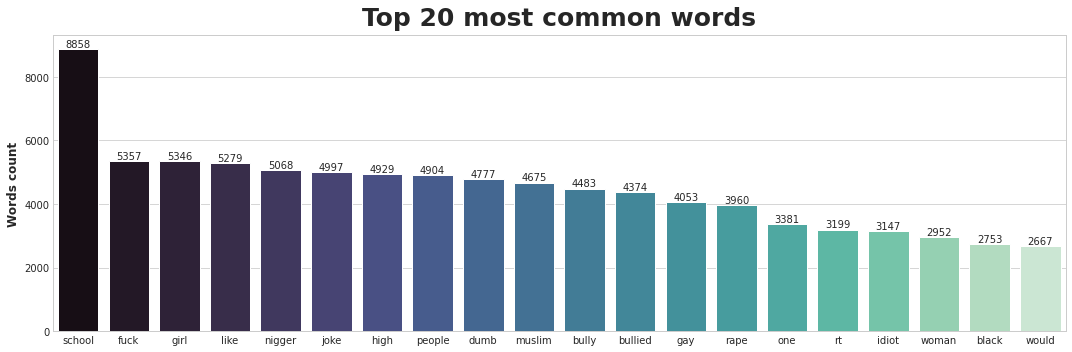

In [50]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(keys, values, palette='mako')
plt.title('Top 20 most common words', size=25)
ax.bar_label(ax.containers[0])
plt.ylabel("Words count")
plt.show()

# 通过Word2Vec进行词嵌入


接下来，使用原始文本推文和预训练的Word2vec模型创建一个词嵌入矩阵。<br>
首先，从X_train向量中创建一个单词列表。

In [51]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

设置嵌入词的维度，即每个转换词的特征数量。

In [52]:
EMBEDDING_DIM = 200

然后通过将训练词和选择的嵌入维度传递给导入的Word2vec对象来实例化Word2Vec模型。

In [53]:
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

在定义嵌入矩阵之前，需要选择最大单词数。从之前创建的词汇字典中提取单词数。

In [54]:
print(f"Vocabulary size: {len(vocabulary) + 1}")

Vocabulary size: 37541


In [55]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

最后定义嵌入矩阵。

In [56]:
# 定义一个形状为(VOCAB_SIZE, EMBEDDING_DIM)的空嵌入矩阵
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# 使用word2vec的预训练值填充嵌入矩阵
for word, token in vocabulary:
    # 检查单词是否存在于word2vec模型的词汇表中
    if word in word2vec_model.wv.key_to_index:
        # 如果单词存在，检索其嵌入向量并将其添加到嵌入矩阵中
        embedding_vector = word2vec_model.wv[word]
        embedding_matrix[token] = embedding_vector

# 打印嵌入矩阵的形状
print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (37541, 200)


## 训练集、验证集、测试集分割


使用标记化的句子来创建训练、验证和测试数据集。
0.64-0.16-0.2

In [57]:
X = tokenized_column
y = df['sentiment'].values

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [59]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

查看目标类别的均衡性：

In [60]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5015],
       [   1, 4967],
       [   2, 4711],
       [   3, 4631],
       [   4, 3879]])

然后在训练集上应用随机过采样。

In [61]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train),np.array(y_train));

In [62]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5015],
       [   1, 5015],
       [   2, 5015],
       [   3, 5015],
       [   4, 5015]])

## PyTorch datasets and dataloaders

三个数据集将被转换为tensor datasets和dataloaders，用于LSTM训练、验证和测试批量提取数据。

In [63]:
train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [64]:
BATCH_SIZE = 32

In [65]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True) 
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

# 使用注意力机制层的PyTorch LSTM模型

下面定义了类：Attention 和 LSTM_Sentiment_Classifier。

Attention类定义了注意力机制。
可以让模型在生成输出时关注输入序列的特定部分。它学习为输入数据的不同部分分配权重，指出它们的相关性。
这个类初始化了一个注意力层，该层考虑了LSTM网络是否是双向的。
在Attention类的forward方法中，
首先计算注意力权重。这些权重是通过将隐藏状态和编码器输出连接起来后应用tanh激活函数来计算的。
然后对注意力权重应用softmax，确保它们和为1，可以解释为概率。

LSTM_Sentiment_Classifier类使用注意力机制来做出预测。
包括一个LSTM网络，它接收嵌入的词表示作为输入并输出隐藏状态。
包括一个注意力层，该层使用这些隐藏状态来计算注意力权重并将它们应用于编码器输出以获得上下文向量。这个上下文向量通过一个全连接层和log-softmax函数来产生最终的输出概率。
在LSTM_Sentiment_Classifier的forward方法中，将输入通过一个嵌入层，然后是LSTM网络。然后我们计算注意力权重并形成一个上下文向量。这个上下文向量作为整个输入序列的总结，由注意力机制的输出加权。将这个上下文向量通过一个全连接层和log-softmax函数来做出最终预测。
最后，定义了一个方法init_hidden来初始化LSTM网络的隐藏状态。根据LSTM网络是否是双向的，可能需要将隐藏状态的大小加倍。
这个带有注意力的LSTM模型允许更好地处理语言理解的复杂性，通过给予文本数据的相关部分更多的重视。这增强了模型理解上下文的能力，从而提高了情感分析任务的性能。


In [66]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, is_bidirectional):
        super(Attention, self).__init__()
        self.is_bidirectional = is_bidirectional
        # 注意力线性层，将输入数据变换到隐藏空间
        self.attn = nn.Linear(hidden_dim * (4 if is_bidirectional else 2), hidden_dim * (2 if is_bidirectional else 1))
        # 计算注意力分数的线性层
        self.v = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        # 在双向LSTM的情况下，连接最后两个隐藏状态
        if self.is_bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=-1)
        else:
            hidden = hidden[-1]
        # 将隐藏状态在序列长度上重复
        hidden_repeated = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        # 计算注意力权重
        attn_weights = torch.tanh(self.attn(torch.cat((hidden_repeated, encoder_outputs), dim=2)))
        # 计算注意力分数
        attn_weights = self.v(attn_weights).squeeze(2)
        # 应用softmax以获得有效的概率
        return nn.functional.softmax(attn_weights, dim=1)


class LSTM_Sentiment_Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, dropout, is_bidirectional):
        super(LSTM_Sentiment_Classifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = lstm_layers
        self.is_bidirectional = is_bidirectional

        # 将输入单词转换为嵌入的嵌入层
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # 处理嵌入的LSTM层
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, lstm_layers, batch_first=True, bidirectional=is_bidirectional)
        # 用于计算上下文向量的注意力层
        self.attention = Attention(hidden_dim, is_bidirectional)
        # 将上下文向量分类到类别的全连接层
        self.fc = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), num_classes)
        # 对输出应用LogSoftmax以获得数值稳定性
        self.softmax = nn.LogSoftmax(dim=1)
        # 用于正则化的Dropout层
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        # 将单词转换为嵌入
        embedded = self.embedding(x)
        # 将嵌入传递给LSTM
        out, hidden = self.lstm(embedded, hidden)
        # 计算注意力权重
        attn_weights = self.attention(hidden[0], out)
        # 通过LSTM输出的加权和计算上下文向量
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        # 对上下文向量进行分类
        out = self.softmax(self.fc(context))
        return out, hidden

    def init_hidden(self, batch_size):
        # 因子根据双向性确定隐藏状态的大小
        factor = 2 if self.is_bidirectional else 1
        # 初始隐藏状态和细胞状态为零
        h0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        c0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        return (h0, c0)

In [67]:
NUM_CLASSES = 5 # 处理一个包含5个类别的多类分类问题
HIDDEN_DIM = 100 # LSTM内部状态（LSTM内部神经网络）的神经元数量
LSTM_LAYERS = 1 # 堆叠的LSTM层数量

IS_BIDIRECTIONAL = False # 将此设置为False以使用单向LSTM，设置为True以使用双向LSTM

LR = 4e-4 # 学习率Learning rate
DROPOUT = 0.5 # LSTM Dropout
EPOCHS = 10 # Number of training epoch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS, DROPOUT, IS_BIDIRECTIONAL)

model = model.to(DEVICE)

# 使用之前定义的嵌入矩阵初始化嵌入层
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
# 允许嵌入矩阵进行微调，以更好地适应我们的数据集并获得更高的准确率
model.embedding.weight.requires_grad = True

# 设置准则（损失函数）
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

print(model)

LSTM_Sentiment_Classifier(
  (embedding): Embedding(37541, 200)
  (lstm): LSTM(200, 100, batch_first=True)
  (attention): Attention(
    (attn): Linear(in_features=200, out_features=100, bias=True)
    (v): Linear(in_features=100, out_features=1, bias=False)
  )
  (fc): Linear(in_features=100, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)


# LSTM训练循环


现在我们将定义一个自定义训练循环，其中包含早停功能，并且只保存验证准确率最高的模型。


In [68]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # 将最佳准确率初始化为0

for e in range(EPOCHS):

    # 列表用于存放每个批次在每个时期的训练和验证损失
    train_loss, valid_loss  = [], []
    # 列表用于存放每个批次在每个时期的训练和验证准确率
    train_acc, valid_acc  = [], []

    # 列表用于存放每个批次在每个时期的训练和验证预测结果
    y_train_list, y_val_list = [], []

    # 初始化训练和验证过程中分类的文本总数和正确分类的文本数
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) # 将特征和目标加载到设备上

        h = model.init_hidden(labels.size(0))

        model.zero_grad() # 重置梯度


        output, h = model(inputs,h) # 从LSTM网络获取输出和隐藏状态
        
        loss = criterion(output, labels)
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) # 在训练集上获取预测值的张量
        y_train_list.extend(y_pred_train.squeeze().tolist()) # 将张量转换为列表，并将值转换为列表
        
        correct += torch.sum(y_pred_train==labels).item() # 每批次计算正确分类的文本数
        total += labels.size(0) # 每批次计算总文本数

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####
    
    with torch.no_grad():
        
        model.eval()
        
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    # 如果验证准确率提高，则保存模型
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 # 如果验证准确率提高，则重置计数器
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 # 如果验证准确率没有提高，则增加计数器
        
    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break
    
    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 92.455110).  Saving model ...
	Train_loss : 0.6216 Val_loss : 0.2278
	Train_acc : 76.074% Val_acc : 92.455%
Epoch 2:Validation accuracy increased (92.455110 --> 92.541436).  Saving model ...
	Train_loss : 0.1708 Val_loss : 0.2152
	Train_acc : 94.413% Val_acc : 92.541%
Epoch 3:Validation accuracy increased (92.541436 --> 92.886740).  Saving model ...
	Train_loss : 0.0973 Val_loss : 0.2211
	Train_acc : 96.923% Val_acc : 92.887%
Epoch 4:Validation accuracy did not increase
	Train_loss : 0.0583 Val_loss : 0.2972
	Train_acc : 98.208% Val_acc : 91.108%
Epoch 5:Validation accuracy did not increase
	Train_loss : 0.0407 Val_loss : 0.2801
	Train_acc : 98.843% Val_acc : 91.695%
Epoch 6:Validation accuracy did not increase
	Train_loss : 0.0270 Val_loss : 0.3276
	Train_acc : 99.274% Val_acc : 91.765%
Epoch 7:Validation accuracy did not increase
	Train_loss : 0.0211 Val_loss : 0.3516
	Train_acc : 99.393% Val_acc : 91.488%
Epoch 8:Validation accurac

In [69]:
# 加载最佳模型
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

# LSTM Testing

In [70]:
def evaluate_model(model, test_loader):
    model.eval()
    y_pred_list = []
    y_test_list = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            test_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, test_h)
            y_pred_test = torch.argmax(output, dim=1)
            y_pred_list.extend(y_pred_test.squeeze().tolist())
            y_test_list.extend(labels.squeeze().tolist())
    
    return y_pred_list, y_test_list

y_pred_list, y_test_list = evaluate_model(model, test_loader)

In [71]:
print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=sentiments))

Classification Report for Bi-LSTM :
               precision    recall  f1-score   support

    religion       0.96      0.94      0.95      1559
         age       0.97      0.98      0.97      1552
   ethnicity       0.97      0.98      0.98      1467
      gender       0.94      0.85      0.89      1445
not bullying       0.78      0.87      0.82      1209

    accuracy                           0.93      7232
   macro avg       0.92      0.92      0.92      7232
weighted avg       0.93      0.93      0.93      7232



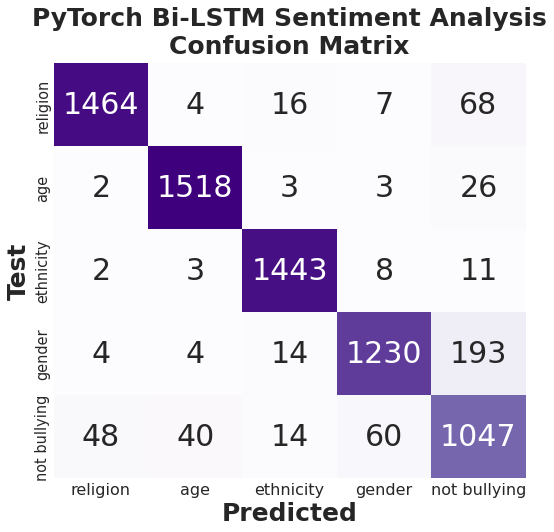

In [72]:
conf_matrix(y_test_list,y_pred_list,'PyTorch Bi-LSTM Sentiment Analysis\nConfusion Matrix', sentiments)

**该算法的性能得分非常高，总体准确率为93%。**<br>
**特别是，对于数据量较多的类别的F1得分超过95%**


# BERT分类


从Hugging Face库加载一个预训练的BERT模型，并对其进行微调以完成分类任务。

再次将数据集分割为训练、验证、测试，因为用与之前（朴素贝叶斯和LSTM）不同的方式标记化句子。

## 训练集、验证集、测试集分割


In [73]:
X = df['text_clean'].values
y = df['sentiment'].values

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [75]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

将文本过采样到多数类别。


In [76]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1))

In [77]:
X_train_os = X_train_os.flatten()
y_train_os = y_train_os.flatten()

In [78]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5015],
       [   1, 5015],
       [   2, 5015],
       [   3, 5015],
       [   4, 5015]])

# BERT Tokenization

由于我们需要为BERT标记推文（获取“输入ids”和“注意力掩码”），我们从Hugging Face库加载特定的BERT标记器BertTokenizer。


In [79]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

然后我们使用加载的Tokenizer定义一个自定义函数bert_tokenizer。

In [80]:
def bert_tokenizer(data):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # 添加`[CLS]`和`[SEP]`特殊标记
            max_length=MAX_LEN,             # 选择最大长度填充pad
            pad_to_max_length=True,         # 将句子填充到最大长度
            return_attention_mask=True      # 返回attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # 将列表转换为tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

由于需要指定最长标记化句子的长度，使用原始BERT tokenizer的“encode”方法对训练推文进行标记化，并查看最长的句子词数。


In [81]:
# Tokenize标记 train tweets
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train]

# 找最长的tokenized tweet
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  82


选择最大长度为128。

In [82]:
MAX_LEN = 128

然后使用自定义bert_tokenizer来标记化训练、验证和测试推文。

In [83]:
train_inputs, train_masks = bert_tokenizer(X_train_os)
val_inputs, val_masks = bert_tokenizer(X_valid)
test_inputs, test_masks = bert_tokenizer(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## 数据预处理 PyTorch BERT模型

使用基于PyTorch的BERT模型，需要将数组转换为PyTorch tensor，并为数据创建数据DataLoader。

In [84]:
# 将目标列转换为PyTorch tensor格式
train_labels = torch.from_numpy(y_train_os)
val_labels = torch.from_numpy(y_valid)
test_labels = torch.from_numpy(y_test)

## Dataloaders

微调BERT模型，批大小为16或32。

In [85]:
batch_size = 32

In [86]:
# 为训练集创建DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# 为验证集创建DataLoader
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# 为测试集创建DataLoader
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# BERT Modeling建模

创建一个自定义的BERT分类器类Bert_Classifier，包括原始的BERT模型（由变换器层组成）和额外的密集层，以执行所需的分类任务。

In [87]:
class Bert_Classifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(Bert_Classifier, self).__init__()
        # 指定BERT的隐藏大小、分类器的隐藏大小以及标签的数量
        n_input = 768
        n_hidden = 50
        n_output = 5

        # 实例化BERT模型
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # 实例化分类器（一个全连接层后跟ReLU激活，然后是另一个全连接层）
        self.classifier = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output)
        )

        # 如果freeze_bert为True，冻结BERT模型权重（用于特征提取而不进行微调）
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # 将输入数据（input_ids和attention_mask）输入到BERT中
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # 从BERT输出中提取`[CLS]`标记的最后一个隐藏状态（对于分类任务非常有用）
        last_hidden_state_cls = outputs[0][:, 0, :]

        # 将提取的隐藏状态输入到分类器中以计算logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

此外，需要定义一个学习率调度器，所以定义了一个自定义的“initalize_model”函数。

In [88]:
# 初始化BERT分类器模型、优化器和学习率调度器的函数
def initialize_model(epochs=4):
    # 实例化BERT分类器
    bert_classifier = Bert_Classifier(freeze_bert=False)

    bert_classifier.to(device)

    # 设置优化器
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # learning rate, set to default value
                      eps=1e-8    # decay, set to default value
                      )

    # 计算总的训练步数
    total_steps = len(train_dataloader) * epochs

    # 定义学习率调度器
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

是否使用GPU（建议进行微调时使用）


In [89]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS=2

然后调用定义的“initialize_model”函数来初始化BERT模型。


In [90]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# BERT Training

在定义了自定义的BERT分类器模型之后，就可以开始训练了。

In [91]:
# 为多类分类任务定义交叉熵损失函数
loss_fn = nn.CrossEntropyLoss()

def bert_train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        # 测量每个时期的耗时
        t0_epoch, t0_batch = time.time(), time.time()

        # 在每个时期的开始重置跟踪变量
        total_loss, batch_loss, batch_counts = 0, 0, 0
        
        ###TRAINING###

        # 将模型置于训练模式
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # 清除任何之前计算的梯度
            model.zero_grad()

            # 执行前向传播并获取logits。
            logits = model(b_input_ids, b_attn_mask)

            # 计算损失并累积损失值
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # 执行反向传播以计算梯度
            loss.backward()

            # 梯度裁剪的范数1.0，以防止“梯度爆炸”
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # 更新模型参数：
            # 微调BERT参数并训练额外的密集层
            optimizer.step()
            # 更新学习率
            scheduler.step()

            # 每100batches打印一次损失值和耗时
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # 计算20批次的耗时
                time_elapsed = time.time() - t0_batch
                
                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                # 重置批次跟踪变量
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # 计算整个训练数据的平均损失
        avg_train_loss = total_loss / len(train_dataloader)

        ###EVALUATION###
        
        # 将模型置于评估模式
        model.eval()
        
        # 定义空列表以存储每个批次的准确性和验证结果
        val_accuracy = []
        val_loss = []

        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)
            
            # 在评估期间，不用更新参数，
            # 通过调用torch.no_grad()方法来指定不想计算张量的梯度
            with torch.no_grad():
                logits = model(batch_input_ids, batch_attention_mask)

            loss = loss_fn(logits, batch_labels)

            val_loss.append(loss.item())

            # 从logits开始获取预测（获取最高logit的索引）
            preds = torch.argmax(logits, dim=1).flatten()

            # 计算验证准确性
            accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)

        # 在验证集上计算平均准确性和损失
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        
        # 在整个训练数据上打印性能
        time_elapsed = time.time() - t0_epoch
        print("-"*61)
        print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
        print("-"*61)
        print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
        print("-"*61)
        print("\n")
    
    print("Training complete!")

In [92]:
bert_train(bert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS)

Start training...

----------
Epoch : 1
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.642614   |   38.95  
   200    |   0.272040   |   38.54  
   300    |   0.254184   |   38.53  
   400    |   0.198068   |   38.50  
   500    |   0.210324   |   38.53  
   600    |   0.183725   |   38.49  
   700    |   0.185555   |   38.51  
   783    |   0.158373   |   31.86  
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   0.265866    |  0.184779  |       94.31       |  324.15  
-------------------------------------------------------------


----------
Epoch : 2
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.115190   |   38.90  
   200    |   0.123147   |   38.50  
   3

# BERT Prediction

定义一个类似于模型“evaluation”的函数，其中我们向模型输入测试数据。

In [93]:
def bert_predict(model, test_dataloader):
    
    # 定义空列表以存储预测结果
    preds_list = []
    
    # 将模型置于评估模式
    model.eval()
    
    for batch in test_dataloader:
        batch_input_ids, batch_attention_mask = tuple(t.to(device) for t in batch)[:2]
        
        # 通过使用"no_grad()"方法避免计算张量的梯度
        with torch.no_grad():
            logit = model(batch_input_ids, batch_attention_mask)
        
        # 获取最高logit的索引
        pred = torch.argmax(logit,dim=1).cpu().numpy()
        # 将预测的类别追加到列表中
        preds_list.extend(pred)

    return preds_list

然后调用定义的函数，并获取测试数据的分类预测。

In [94]:
bert_preds = bert_predict(bert_classifier, test_dataloader)

In [95]:
print('Classification Report for BERT :\n', classification_report(y_test, bert_preds, target_names=sentiments))

Classification Report for BERT :
               precision    recall  f1-score   support

    religion       0.95      0.96      0.96      1567
         age       0.99      0.98      0.98      1553
   ethnicity       0.99      0.98      0.99      1472
      gender       0.94      0.90      0.92      1447
not bullying       0.82      0.86      0.84      1213

    accuracy                           0.94      7252
   macro avg       0.94      0.94      0.94      7252
weighted avg       0.94      0.94      0.94      7252



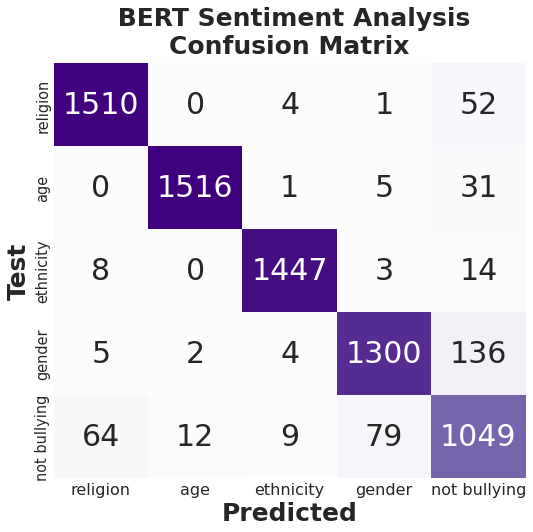

In [96]:
conf_matrix(y_test, bert_preds,' BERT Sentiment Analysis\nConfusion Matrix', sentiments)

**BERT分类器的性能得分相当高，而且高于使用LSTM模型获得的得分，整体准确率约为95%，F1得分超过95%。**